# Control of a "spacecraft" platform with a reaction wheel

Import modules and configure the notebook.

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt

# This is a custom interface to the pybullet simulator
import ae353_platform

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Given a choice of ground roll angle $\phi$, the equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $\dot{q}_1$ is the platform velocity
* $v_2$ is the wheel velocity
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w
$$

and parameter values are defined as follows:

In [2]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

# Control wheel velocity only (no gravity)

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [3]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore platform) are:

$$
\begin{aligned}
J_1 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

In [4]:
# Define variables
v2, tau = sym.symbols('v2, tau')

# Define right-hand side of ODEs
f = sym.Matrix([
    - ((J1 + J2) / (J1 * J2)) * tau,
])

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

# Display the result
f

Matrix([[-33*tau]])

Choose an equilibrium point. If we solve

$$
\begin{bmatrix} 0 \end{bmatrix}
=
f \left( \begin{bmatrix} v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

by hand (easy in this case), it is clear that $\tau_e=0$, but that we can choose any value of $v_{2e}$. Let's choose $v_{2e}=2 \pi$.

In [5]:
# Define equilibrium point
v2e = 2. * np.pi
taue = 0.

# Check that it really is an equilibrium point
# - Create a lambda function to allow numerical evaluation of f
f_num = sym.lambdify([v2, tau], f)
# - Evaluate f at the candidate equilibrium point, checking that the result is zero
print(f_num(v2e, taue))

[[-0.]]


Linearize the equations of motion about the equilibrium point to produce the state-space model

$$ \dot{x} = Ax + Bu $$

with the following state and input:

$$
x = \begin{bmatrix} v_2 - v_{2e} \end{bmatrix}
\qquad\qquad
u = \begin{bmatrix} \tau - \tau_e \end{bmatrix}
$$

In [6]:
# Find A and B in symbolic form
A_sym = f.jacobian([v2])
B_sym = f.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([v2, tau], A_sym)
B_num = sym.lambdify([v2, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(v2e, taue).astype(float)
B = B_num(v2e, taue).astype(float)

# Show the results
print('A =')
print(A)
print('\nB =')
print(B)

A =
[[0.]]

B =
[[-33.]]


Design and implement linear state feedback with the form

$$ u = - K x $$

for some appropriately sized gain matrix $K$.

In [16]:
# Define controller
class Controller:
    def __init__(self, K, v2e, taue):
        self.K = K
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -wheel_velocity-tau
        return wheel_torque

# Choose gain matrix
K = np.array([[-1.]])

# Create instance of controller with this gain matrix
controller = Controller(K, v2e, taue)

Run simulation.

In [17]:
# Reset the simulator with given initial conditions
simulator.reset(
    platform_angle=0.,
    platform_velocity=0.,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset the controller
controller.reset()

# Run the simulator
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot results.

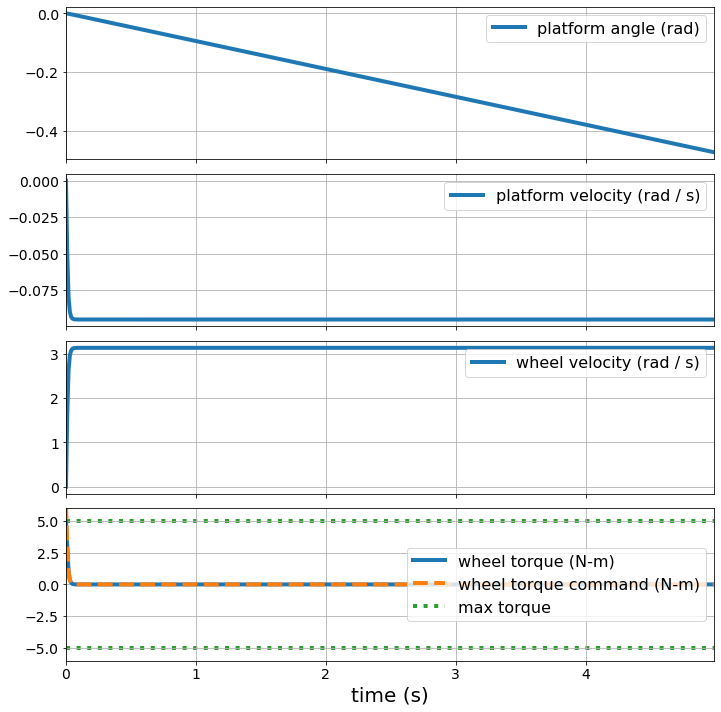

In [18]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (rad / s)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (rad / s)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Find $x(t)$ numerically (at each sample time).

In [10]:
# Define initial conditions
x0 = np.array([
    data['wheel_velocity'][0] - v2e,
])

# Create empty array to hold state at each time
x = []

# Compute state at each time
for t in data['t']:
    x.append(linalg.expm((A - B @ K) * t) @ x0)
x = np.array(x)

# Extract platform angle and platform velocity
wheel_velocity_linear = x[:, 0] + v2e

Plot results.

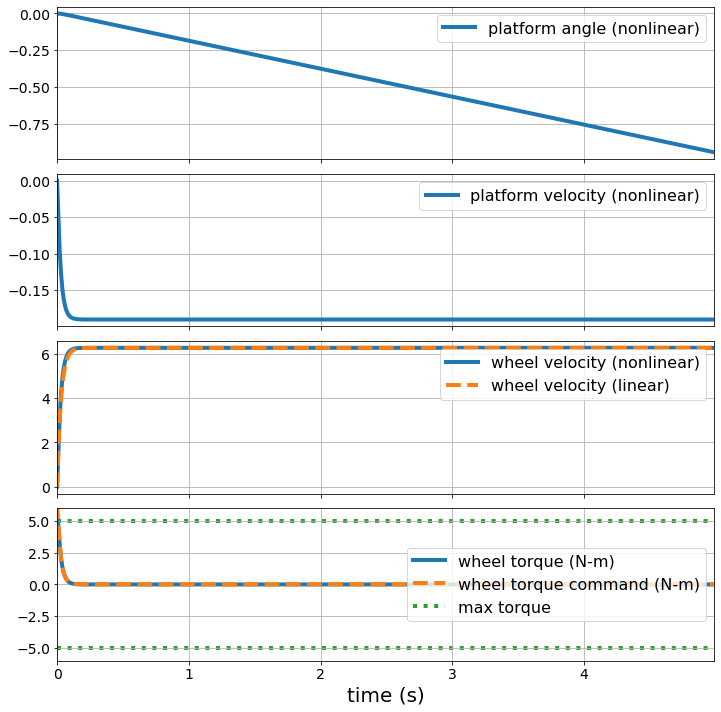

In [11]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (nonlinear)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (nonlinear)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (nonlinear)', linewidth=4,
)
ax_wheel.plot(
    data['t'], wheel_velocity_linear,
    '--', label='wheel velocity (linear)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Find $x(t)$ symbolically (at arbitrary time).

In [ ]:
# # Uncomment for another example gain matrix
# K = np.array([[- 5. / 33.]])

# Convert (A - B K) from numeric to symbolic
F = sym.nsimplify(sym.Matrix(A - B @ K), rational=True)

# Define symbolic variable to represent time
t = sym.symbols('t')

# Define symbolic variables to represent initial conditions
x_1i = sym.symbols('x_1i')

# Define initial conditions
x0 = sym.Matrix([x_1i])

# Solve closed-loop system
x = sym.exp(F * t) @ x0

# Show result
x

# Control platform angle only (no gravity)

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [ ]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore wheel) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

In [ ]:
# Define variables
q1, v1, tau = sym.symbols('q1, v1, tau')

# Define right-hand side of ODEs
f = sym.Matrix([
    v1,
    (1 / J1) * tau,
])

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

# Display the result
f

Choose an equilibrium point. If we solve

$$
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

by hand (easy in this case), it is clear that $v_{1e}=0$ and $\tau_e=0$, but that we can choose any value of $q_{1e}$. Let's choose $q_{1e}=0$.

In [ ]:
# Define equilibrium point
q1e = 0.
v1e = 0.
taue = 0.

# Check that it really is an equilibrium point
# - Create a lambda function to allow numerical evaluation of f
f_num = sym.lambdify([q1, v1, tau], f)
# - Evaluate f at the candidate equilibrium point, checking that the result is zero
print(f_num(q1e, v1e, taue))

Linearize the equations of motion about the equilibrium point to produce the state-space model

$$ \dot{x} = Ax + Bu $$

with the following state and input:

$$
x = \begin{bmatrix} q_1 - q_{1e} \\ v_1 - v_{1e} \end{bmatrix}
\qquad\qquad
u = \begin{bmatrix} \tau - \tau_e \end{bmatrix}
$$

In [ ]:
# Find A and B in symbolic form
A_sym = f.jacobian([q1, v1])
B_sym = f.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, v1, tau], A_sym)
B_num = sym.lambdify([q1, v1, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, v1e, taue).astype(float)
B = B_num(q1e, v1e, taue).astype(float)

# Show the results
print('A =')
print(A)
print('\nB =')
print(B)

Design and implement linear state feedback with the form

$$ u = - K x $$

for some appropriately sized gain matrix $K$.

In [ ]:
# Define controller
class Controller:
    def __init__(self, K, q1e, v1e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque

# Choose gain matrix
K = np.array([[1., 1.]])

# Create instance of controller with this gain matrix
controller = Controller(K, q1e, v1e, taue)

Run simulation.

In [ ]:
# Reset the simulator with given initial conditions
simulator.reset(
    platform_angle=0.5,
    platform_velocity=0.,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset the controller
controller.reset()

# Run the simulator
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot results.

In [ ]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (rad / s)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (rad / s)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Find $x(t)$ numerically (at each sample time).

In [ ]:
# Define initial conditions
x0 = np.array([
    data['platform_angle'][0] - q1e,
    data['platform_velocity'][0] - v1e,
])

# Create empty array to hold state at each time
x = []

# Compute state at each time
for t in data['t']:
    x.append(linalg.expm((A - B @ K) * t) @ x0)
x = np.array(x)

# Extract platform angle and platform velocity
platform_angle_linear = x[:, 0] + q1e
platform_velocity_linear = x[:, 1] + v1e

Plot results.

In [ ]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (nonlinear)', linewidth=4,
)
ax_platform_angle.plot(
    data['t'], platform_angle_linear,
    '--', label='platform angle (linear)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (nonlinear)', linewidth=4,
)
ax_platform_velocity.plot(
    data['t'], platform_velocity_linear,
    '--', label='platform velocity (linear)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (nonlinear)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Find $x(t)$ symbolically (at arbitrary time).

In [ ]:
# # Uncomment for another example gain matrix
# K = np.array([[6., 5.]])
# K = np.array([[-6., 1.]])

# Convert (A - B K) from numeric to symbolic
F = sym.nsimplify(sym.Matrix(A - B @ K), rational=True)

# Define symbolic variable to represent time
t = sym.symbols('t')

# Define symbolic variables to represent initial conditions
x_1i = sym.symbols('x_1i')
x_2i = sym.symbols('x_2i')

# Define initial conditions
x0 = sym.Matrix([x_1i, x_2i])

# Solve closed-loop system
x = sym.exp(F * t) @ x0

# Show result
x

# Control platform angle and wheel velocity with gravity

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [ ]:
simulator = ae353_platform.Simulator(
    display=True,
    roll=(np.pi / 2),
)

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

In [ ]:
# Define variables
q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')

# Define right-hand side of ODEs
f = sym.Matrix([
    v1,
    (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
    (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
])

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

# Display the result
f

Choose an equilibrium point. If we solve

$$
\begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

by hand (easy in this case), we see that the only possible choices are those for which $q_1$ is an integer multiple of $\pi$ (i.e., either "platform down" or "platform up"). Let's choose $q_1=\pi$.

In [ ]:
# Define equilibrium point
q1e = np.pi
v1e = 0.
v2e = 0.
taue = 0.

# Check that it really is an equilibrium point
# - Create a lambda function to allow numerical evaluation of f
f_num = sym.lambdify([q1, v1, v2, tau], f)
# - Evaluate f at the candidate equilibrium point, checking that the result is zero
print(f_num(q1e, v1e, v2e, taue))

Linearize the equations of motion about the equilibrium point to produce the state-space model

$$ \dot{x} = Ax + Bu $$

with the following state and input:

$$
x = \begin{bmatrix} q_1 - q_{1e} \\ v_1 - v_{1e} \\ v_2 - v_{2e} \end{bmatrix}
\qquad\qquad
u = \begin{bmatrix} \tau - \tau_e \end{bmatrix}
$$

In [ ]:
# Find A and B in symbolic form
A_sym = f.jacobian([q1, v1, v2])
B_sym = f.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, v1e, v2e, taue).astype(float)
B = B_num(q1e, v1e, v2e, taue).astype(float)

# Show the results
print('A =')
print(A)
print('\nB =')
print(B)

Design and implement linear state feedback with the form

$$ u = - K x $$

for some appropriately sized gain matrix $K$.

In [ ]:
# Define controller
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque

# Choose gain matrix
K = np.array([[100., 50., 1.]])

# Create instance of controller with this gain matrix
controller = Controller(K, q1e, v1e, v2e, taue)

Run simulation.

In [ ]:
# Reset the simulator with given initial conditions
simulator.reset(
    platform_angle=(np.pi - 0.1),
    platform_velocity=0.,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset the controller
controller.reset()

# Run the simulator
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot results.

In [ ]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (rad / s)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (rad / s)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Find $x(t)$ numerically (at each sample time).

In [ ]:
# Define initial conditions
x0 = np.array([
    data['platform_angle'][0] - q1e,
    data['platform_velocity'][0] - v1e,
    data['wheel_velocity'][0] - v2e,
])

# Create empty array to hold state at each time
x = []

# Compute state at each time
for t in data['t']:
    x.append(linalg.expm((A - B @ K) * t) @ x0)
x = np.array(x)

# Extract platform angle, platform velocity, and wheel velocity
platform_angle_linear = x[:, 0] + q1e
platform_velocity_linear = x[:, 1] + v1e
wheel_velocity_linear = x[:, 2] + v2e

Plot results.

In [ ]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (
        ax_platform_angle,
        ax_platform_velocity,
        ax_wheel,
        ax_torque
    ) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Platform angle
ax_platform_angle.plot(
    data['t'], data['platform_angle'],
    label='platform angle (nonlinear)', linewidth=4,
)
ax_platform_angle.plot(
    data['t'], platform_angle_linear,
    '--', label='platform angle (linear)', linewidth=4,
)
ax_platform_angle.grid()
ax_platform_angle.legend(fontsize=16)
ax_platform_angle.tick_params(labelsize=14)

# Platform velocity
ax_platform_velocity.plot(
    data['t'], data['platform_velocity'],
    label='platform velocity (nonlinear)', linewidth=4,
)
ax_platform_velocity.plot(
    data['t'], platform_velocity_linear,
    '--', label='platform velocity (linear)', linewidth=4,
)
ax_platform_velocity.grid()
ax_platform_velocity.legend(fontsize=16)
ax_platform_velocity.tick_params(labelsize=14)

# Wheel velocity
ax_wheel.plot(
    data['t'], data['wheel_velocity'],
    label='wheel velocity (nonlinear)', linewidth=4,
)
ax_wheel.plot(
    data['t'], wheel_velocity_linear,
    '--', label='wheel velocity (linear)', linewidth=4,
)
ax_wheel.grid()
ax_wheel.legend(fontsize=16)
ax_wheel.tick_params(labelsize=14)

# Wheel torque
ax_torque.plot(
    data['t'], data['wheel_torque'],
    label='wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['wheel_torque_command'],
    '--', label='wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C2', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C2', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()